In [1]:
import os
import glob
import random
import numpy as np
import cv2

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

### Load and Split Dataset

In [6]:
# Define folder paths
single_path = "marital-data\\single"
married_path = "marital-data\\married"
widow_path = "widow-gen\\man"
aug_data = "widow-gen\\woman"

# Lists for images and labels
images = []
labels = []

def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png')):  
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)

load_images_from_folder(single_path, 0)   
load_images_from_folder(married_path, 1)  
load_images_from_folder(widow_path, 2)  
load_images_from_folder(aug_data, 2)

images = np.array(images)
labels = np.array(labels)

train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)

print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Training images shape: (1086, 224, 224, 3)
Training labels shape: (1086,)
Validation images shape: (466, 224, 224, 3)
Validation labels shape: (466,)


### Calculate classes ratios

In [7]:
# Calculate the percentage of each class in the training dataset
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
train_percentages = train_counts / len(train_labels) * 100

# Calculate the percentage of each class in the validation dataset
unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
val_percentages = val_counts / len(val_labels) * 100

# Display the class distribution
for label, percentage in zip(unique_train_labels, train_percentages):
    print(f"Training Class {label}: {percentage:.2f}%")

for label, percentage in zip(unique_val_labels, val_percentages):
    print(f"Validation Class {label}: {percentage:.2f}%")


Training Class 0: 27.35%
Training Class 1: 27.72%
Training Class 2: 44.94%
Validation Class 0: 27.47%
Validation Class 1: 27.68%
Validation Class 2: 44.85%


### Plot sample of the Dataset ###

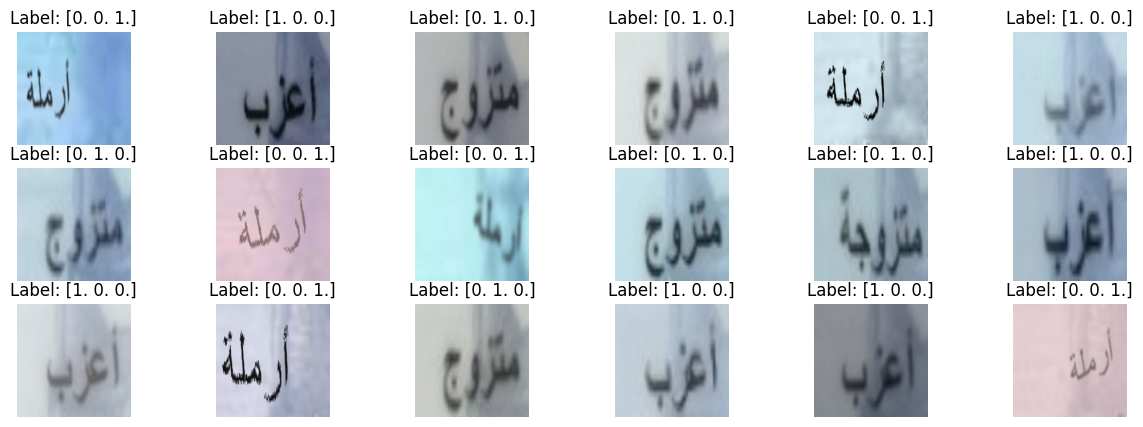

In [8]:
train_labels_one_hot = to_categorical(train_labels, num_classes=3)
val_labels_one_hot = to_categorical(val_labels, num_classes=3)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(32)  # Adjust batch size as needed
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels_one_hot)).batch(32)


def plot_images_from_dataset(dataset, num_images=18):
    # Take a batch from the dataset
    for images, labels in dataset.take(1): 
        n = min(num_images, images.shape[0])  
        plt.figure(figsize=(15, 5))  
        for i in range(n):
            plt.subplot(3, 6, i + 1)  # Create a grid for the images
            plt.imshow(images[i].numpy())  # Convert tensor to numpy for plotting
            plt.title(f'Label: {labels[i].numpy()}')  # Show the label
            plt.axis('off')  # Hide axes
        plt.show()

# Plot 18 images from the train dataset
plot_images_from_dataset(train_dataset, num_images=18)

### Baseline Model: Simplle CNN 

In [9]:

def baseline_model(input_shape):
    X_input = Input(input_shape)
    

    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(32, (5, 5), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    
    # Output Layer for 3 Classes
    X = Dense(3, activation='softmax')(X)  # Change 1 to 3 and sigmoid to softmax

    model = Model(inputs=X_input, outputs=X, name='maritalClassification')    
    return model

In [11]:
input_shape = train_images.shape[1:]
marital_model = baseline_model(input_shape)
marital_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
marital_model.summary()

Model: "maritalClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 226, 226, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 226, 226, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 408608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 408608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │     1,225,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,228,387 (4.69 MB)

 Trainable params: 1,228,323 (4.69 MB)

 Non-trainable params: 64 (256.00 B)

### Training

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

#class_weight_dict = {0: 1.0, 1: 1.0, 2: 1.0}
history = marital_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    #class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']


Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 829ms/step - accuracy: 0.9721 - loss: 0.9502 - val_accuracy: 0.6717 - val_loss: 125.8622
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 912ms/step - accuracy: 0.9906 - loss: 0.3595 - val_accuracy: 0.9378 - val_loss: 4.3349
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 843ms/step - accuracy: 0.9923 - loss: 0.1260 - val_accuracy: 0.7940 - val_loss: 25.7128
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 773ms/step - accuracy: 0.9962 - loss: 0.0315 - val_accuracy: 0.9335 - val_loss: 7.9792
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 797ms/step - accuracy: 0.9973 - loss: 0.1422 - val_accuracy: 0.9742 - val_loss: 1.4047
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 824ms/step - accuracy: 0.9976 - loss: 0.0436 - val_accuracy: 0.9957 - val_loss: 0.1842
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 850ms/step - accuracy: 0.9983 - loss: 0.0336 - val_accuracy: 0.9657 - val_loss: 3.4940
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 805ms/step - accuracy: 0.9937 - loss: 0.1131 - val_a

### Evaluation Plot (val vs train)

Training Accuracy: 1.0
Validation Accuracy: 0.991416335105896


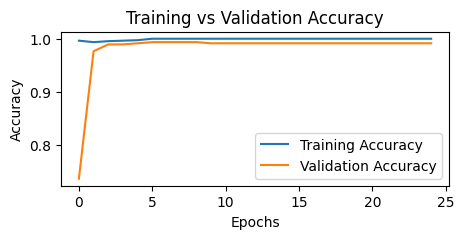

In [27]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Accuracy:", training_accuracy[-1])  
print("Validation Accuracy:", validation_accuracy[-1]) 

# Plotting training and validation accuracy
plt.figure(figsize=(5, 2))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Final Eval

In [14]:
# Step 1: Get predictions for the validation set
val_predictions_prob = marital_model.predict(val_images)
val_predictions = val_predictions_prob.argmax(axis=1)  # Use argmax for multi-class predictions max class prob per row

# Step 2: Calculate F1 score (macro, micro, or weighted depending on your needs)
f1 = f1_score(val_labels, val_predictions, average='weighted')  # Change 'weighted' to 'macro' or 'micro' if needed

# Step 3: Calculate confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

print("Confusion Matrix:\n", cm)

# Additional metrics
#print("FN/FP Ratio:", fn / fp if fp != 0 else 'Inf')  
print("F1-score:", f1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step
Confusion Matrix:
 [[126   1   1]
 [  0 129   0]
 [  0   0 209]]
F1-score: 0.9956979609519419


In [15]:
class_labels = ['Class 0 (Negative)', 'Class 1 (Positive)', 'Class 2 (Minor)']

# Initialize metrics dictionary
metrics = {}
num_classes = cm.shape[0]

# Calculate TP, FP, FN, TN for each class
for i in range(num_classes):
    TP = cm[i, i]  # True Positive
    FN = np.sum(cm[i, :]) - TP  # False Negative
    FP = np.sum(cm[:, i]) - TP  # False Positive
    TN = np.sum(cm) - (TP + FP + FN)  # True Negative

    metrics[class_labels[i]] = {
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    }

# Print calculated metrics with labels
for class_label, metric in metrics.items():
    print(f"{class_label}:")
    print(f"  TP: {metric['TP']}")
    print(f"  FP *: {metric['FP']}")
    print(f"  FN *: {metric['FN']}")
    print(f"  TN: {metric['TN']}")

Class 0 (Negative):
  TP: 126
  FP *: 0
  FN *: 2
  TN: 338
Class 1 (Positive):
  TP: 129
  FP *: 1
  FN *: 0
  TN: 336
Class 2 (Minor):
  TP: 209
  FP *: 1
  FN *: 0
  TN: 256


### Save model & weights

In [30]:
#marital_model.save('marital_model5.keras')
#marital_model.save_weights('marital_model5.weights.h5')

In [ ]:
# m/f class weight ratio = 1:30
# no dropout
#20 epoch
# aug applied
#fn: 0 fp:1

In [ ]:
# inc female class from 3% to 23% by augmentations
